<a href="https://colab.research.google.com/github/ashvar1/helloworld/blob/master/WebScrapingWithPythonPart2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Web Scraping with Python Part 2

Some terms in this notebook are in bold, blue, and underlined, like the following: [**web scraping**](#scrollTo=w8uce2RFUNAf). If you see a term that's in bold, that means that it's defined in the Glossary section at the bottom of this page. Clicking a term in bold will take you to its definition. The term only appears in bold the first time it appears in the notebook.

This class explores solutions to two problems that we might encounter when web scraping. These two are:
1. The response in our program does not match what we see in our browser
2. Some or all of the data is loaded dynamically

We will be scraping Yahoo Finance for stock data. Specifically, we will be attempting to retrieve all of the [daily stock data for Apple in year 2020 at this link](https://finance.yahoo.com/quote/AAPL/history?period1=1577836800&period2=1609372800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true). While doing this, we will encounter both of the problems introduced earlier.

## Problem 1: Response does not match the browser

### Encountering the problem

When we try to access the page that we are trying to scrape in the way that we normally do, we get a weird error. Run the following code cells to see what happens.

In [ ]:
#allows us to access the internet from our Python programs
import requests

#provides us with functions to search through the HTML of a web page
from bs4 import BeautifulSoup

In [ ]:
#the website we want to scrape
url = "https://finance.yahoo.com/quote/AAPL/history?period1=1577836800&period2=1609372800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true"

#standard boilerplate code we use every time we do web scraping
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')

#this displays all of the text in the main part of the page
#with any whitespace before and after the text removed
print(soup.body.get_text(strip=True))

Why does the website not load in the way we expect? In this case, the issue is that Yahoo Finance does not like our "User-Agent" **[request header](#scrollTo=hZfah3C8qgF8)**.

When we send a request, included in that request are headers, which provide additional information about our request. For example, some headers state our preferred data formats or preferred languages for the text in the page. 

The "User-Agent" header lets the website know how we are accessing their page; if we are using a standard web browser, then "User-Agent" will state our browser, our operating system, and some additional information.

We can check the "User-Agent" header that gets sent by requests by writing the following:

In [ ]:
print(page.request.headers["User-Agent"])

Yahoo Finance is most likely withholding access to their website because our "User-Agent" header clearly states that we are coming from a Python program using the requests **[library](#scrollTo=gub_2dgjQXst)**; it knows that we are trying to scrape their page.

### Solving the problem

We can get around these restrictions by changing our "User-Agent" header to make it seem as if we are using a browser to access the website.

We can view the "User-Agent" that gets sent by our browser by going to Developer Tools and navigating to the Network section,

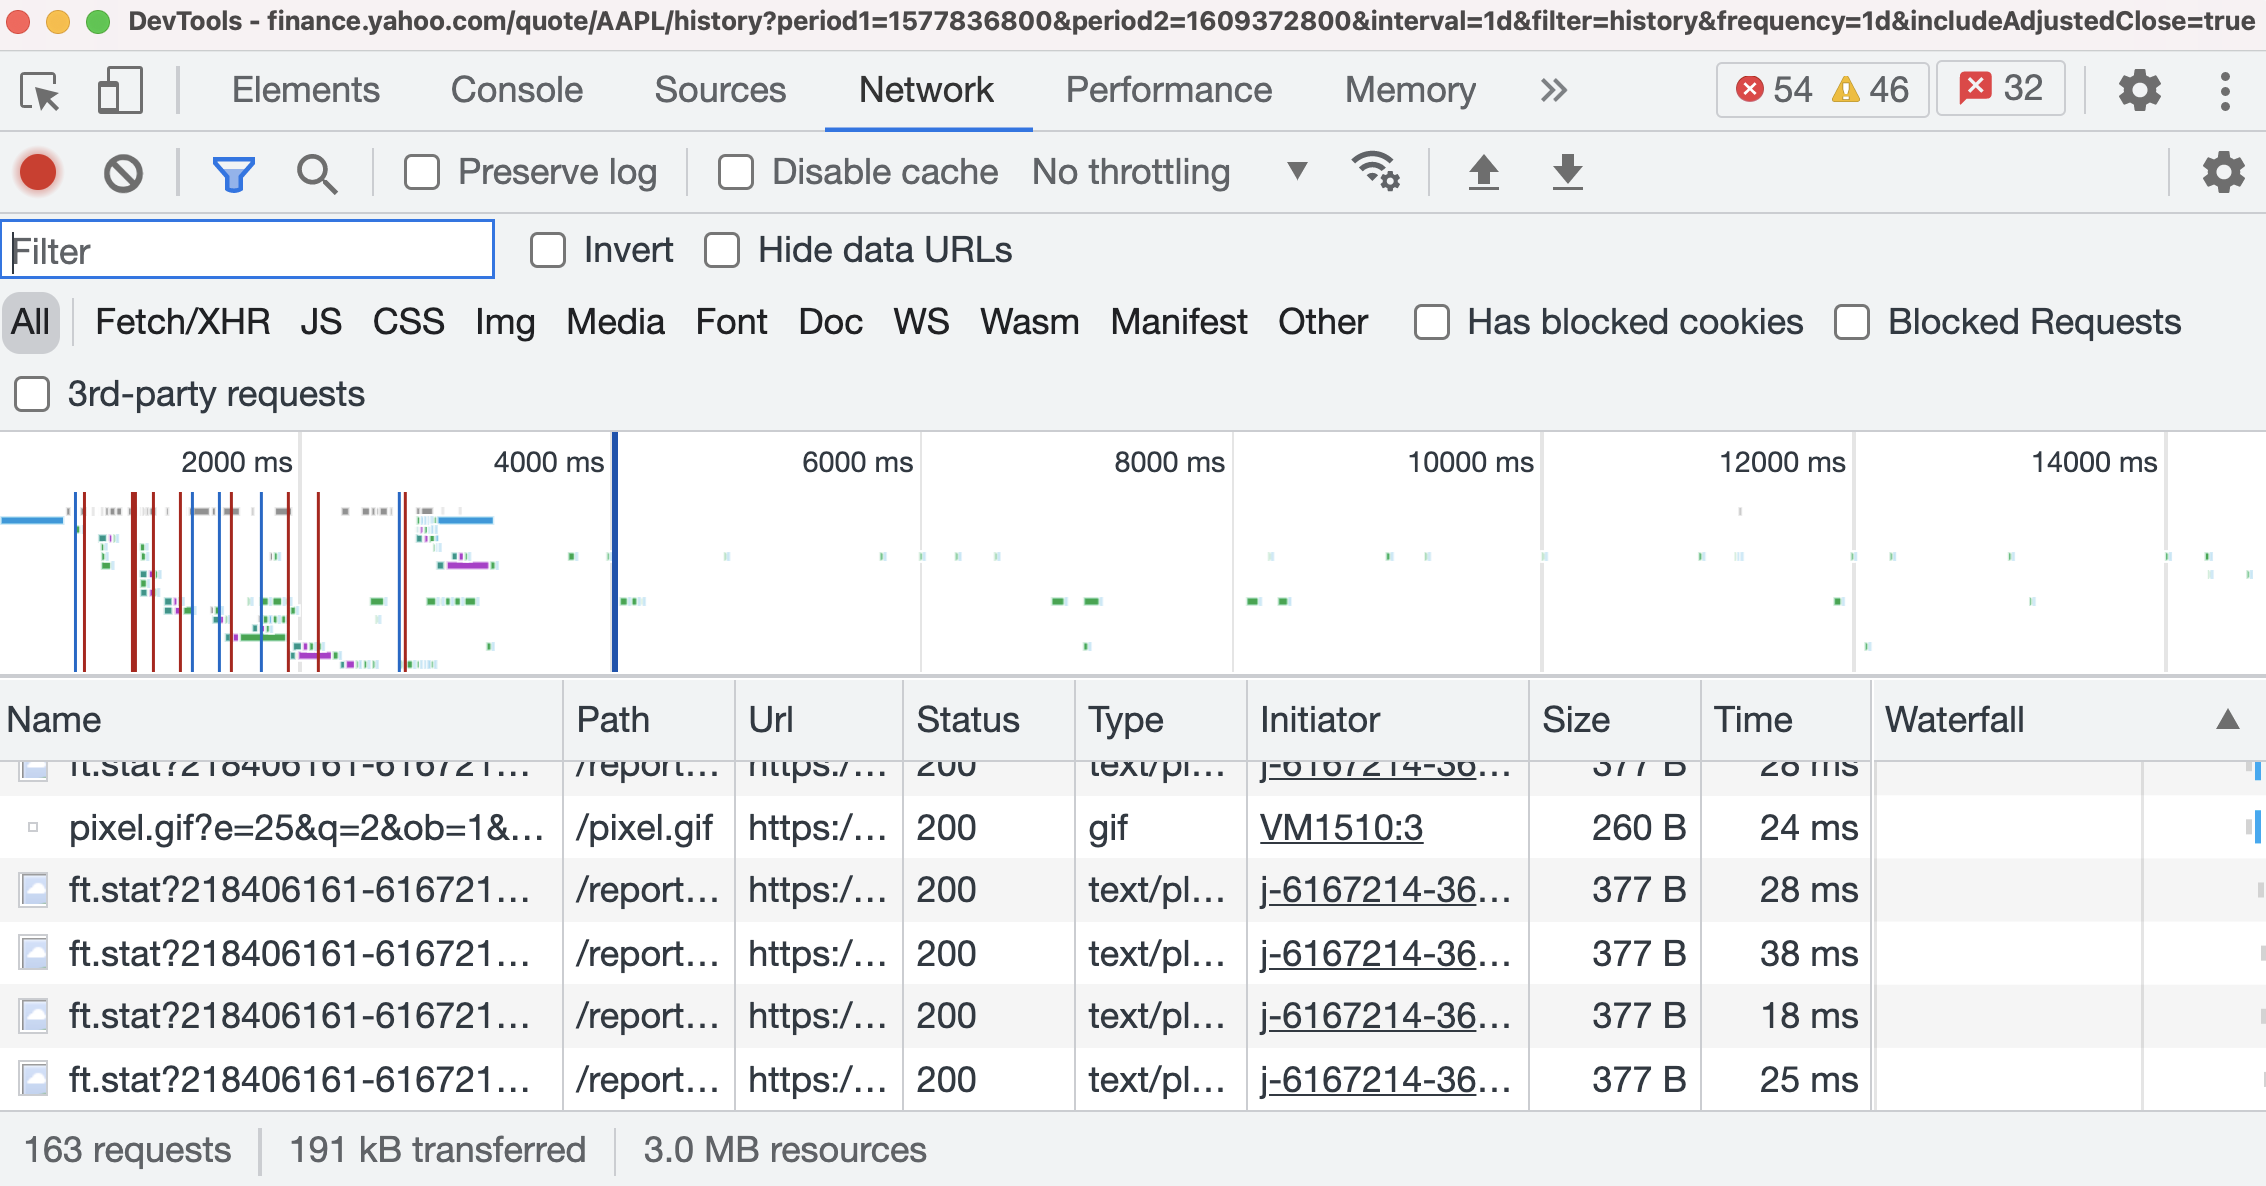

clicking on any of the links under Name,

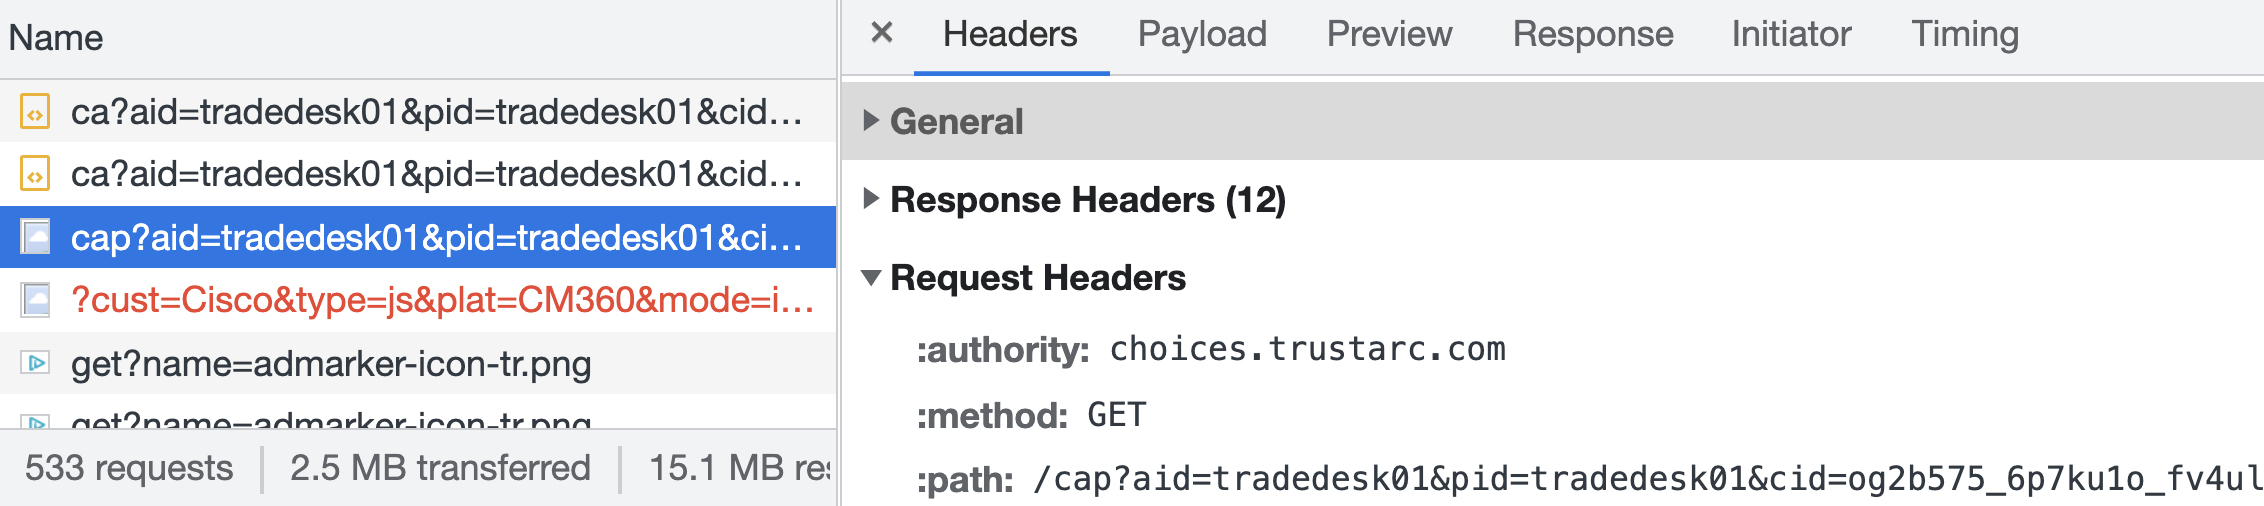

and then under Headers, scrolling down until we see "User-Agent".

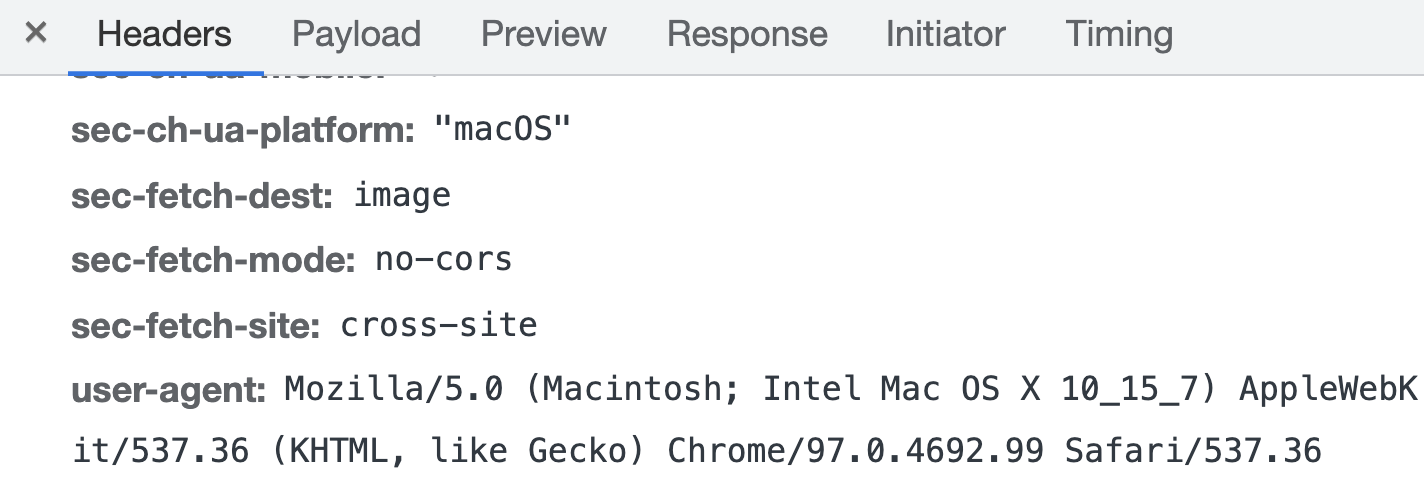

So, the "User-Agent" that gets sent by my browser is:

Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.99 Safari/537.36

Let's try to access Yahoo Finance using a "User-Agent" header that makes it seem as if we are using a web browser.

In [ ]:
#the website we want to scrape
url = "https://finance.yahoo.com/quote/AAPL/history?period1=1577836800&period2=1609372800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true"

#the user-agent header must be present
legitimateUserAgent = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.99 Safari/537.36"
headers = {"user-agent": legitimateUserAgent}

#standard boilerplate code we use every time we do web scraping
page = requests.get(url, headers=headers)
soup = BeautifulSoup(page.content, 'html.parser')

#this displays all of the text in the main part of the page
#with any whitespace before and after the text removed
print(soup.body.get_text(strip=True))

We no longer see the error message from earlier.

Now that we seem to have access to all of the data from the page, let's figure out a plan of attack on how to retrieve the data we want.

### Figuring out a plan of attack

When we navigate to the Yahoo Finance historical data website, we should see a table like the one below (with different dates). Our goal is to obtain all of the information in this table. The table will always have seven columns: the date; the [**open**](#scrollTo=65dBHcuEdZXl), [**high**](#scrollTo=0OdTvq0Bd7za), [**low**](#scrollTo=HVxy4hY5fLzf), [**close**](#scrollTo=xo1CoVpMeE63), and [**adjusted close**](#scrollTo=93xZIjgKeapG) prices; and the [**volume**](#scrollTo=SxRo-ZZGev5w) of stocks traded.

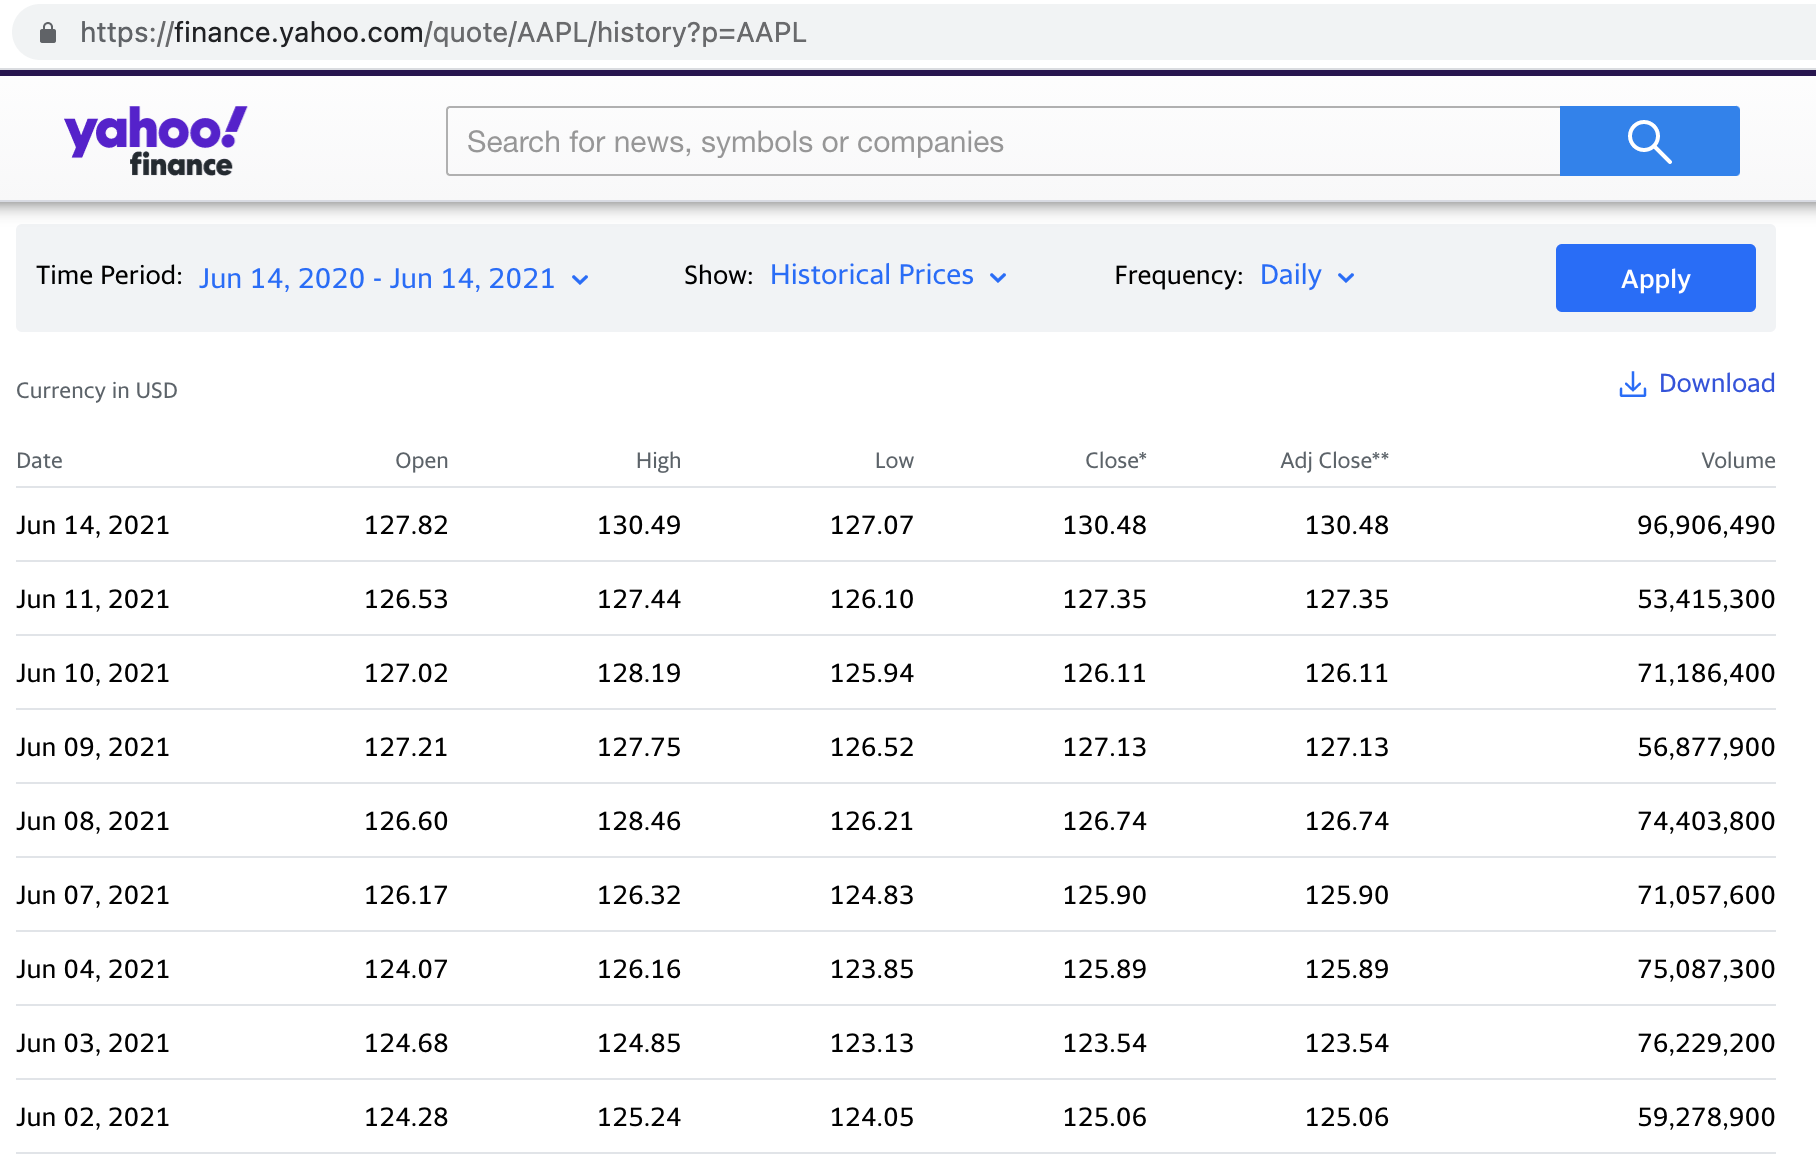

Open up [**Developer Tools**](#scrollTo=qsl8NAb3QOgq). Notice that the [**element**](#scrollTo=dJD25XUAz_AH) with the [**tag**](#scrollTo=KYu6klsVQUwx) *table*  and with the [**attribute**](#scrollTo=HMvKArft0DTV) data-test="historical-prices" contains all of the information in the table we're interested in.

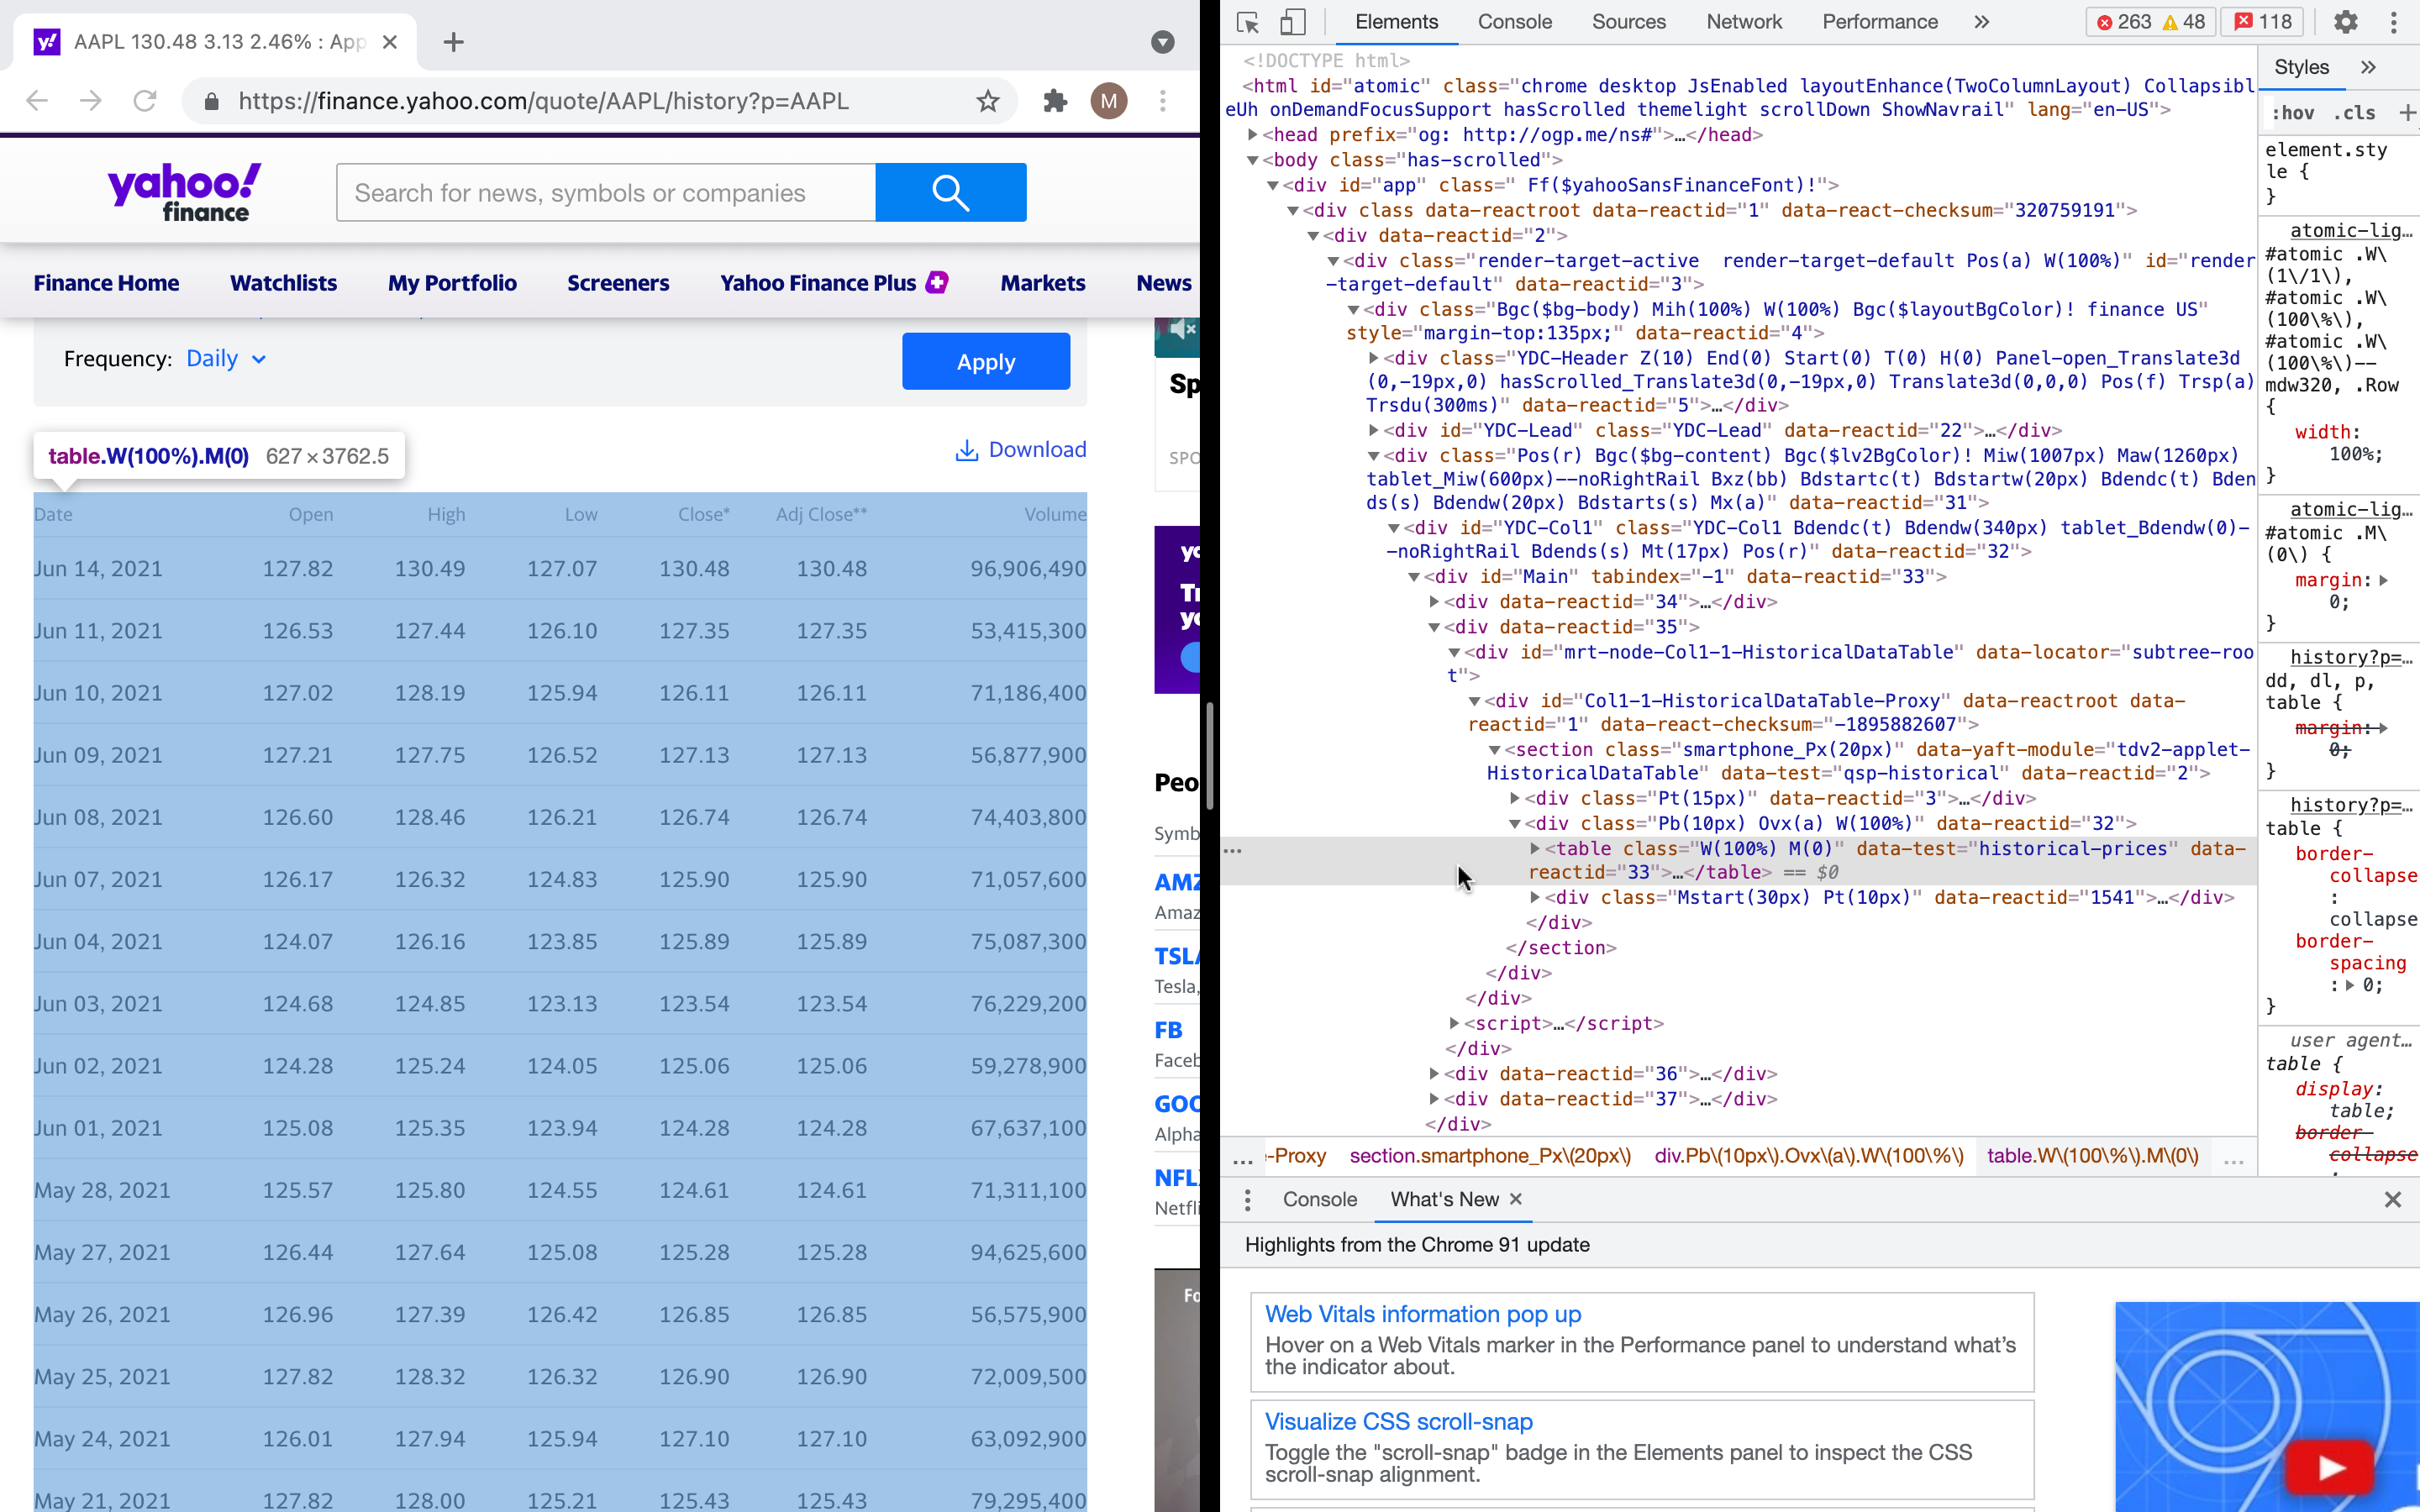

Inside of the *table* element is the *tbody* element, which contains the actual content of the table.

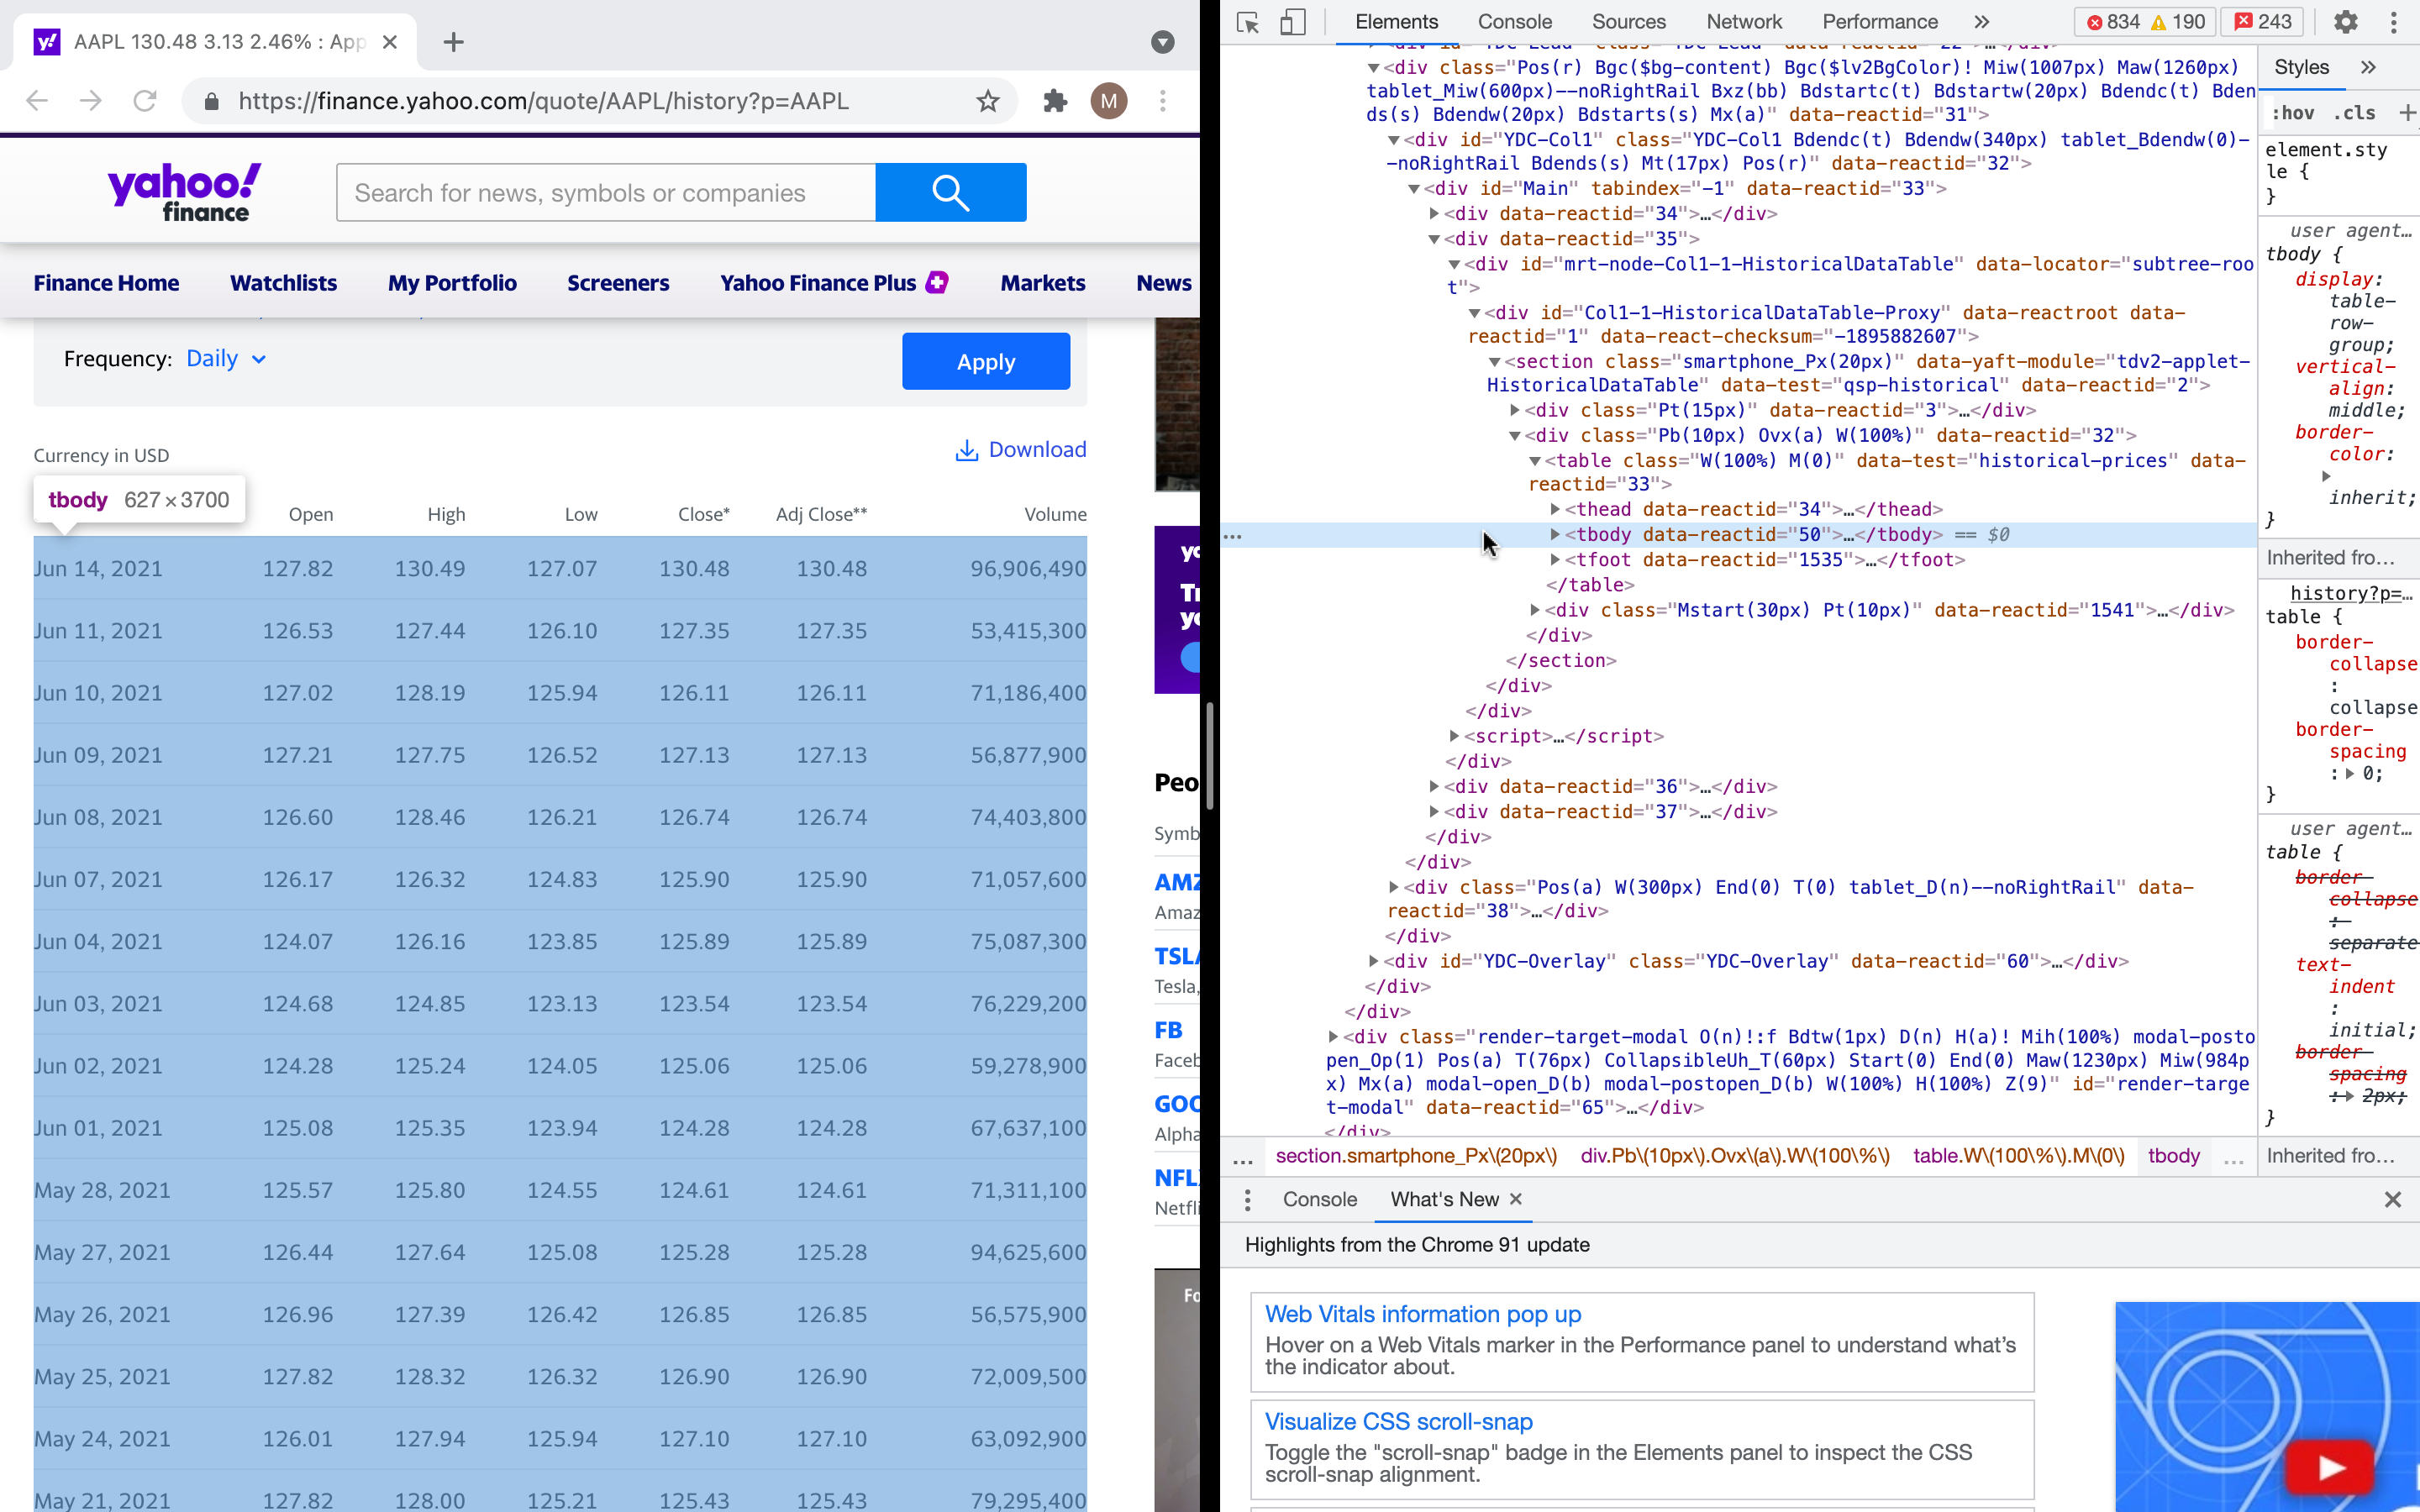

Inside of the *tbody* element, each row in the table is in a *tr* element.

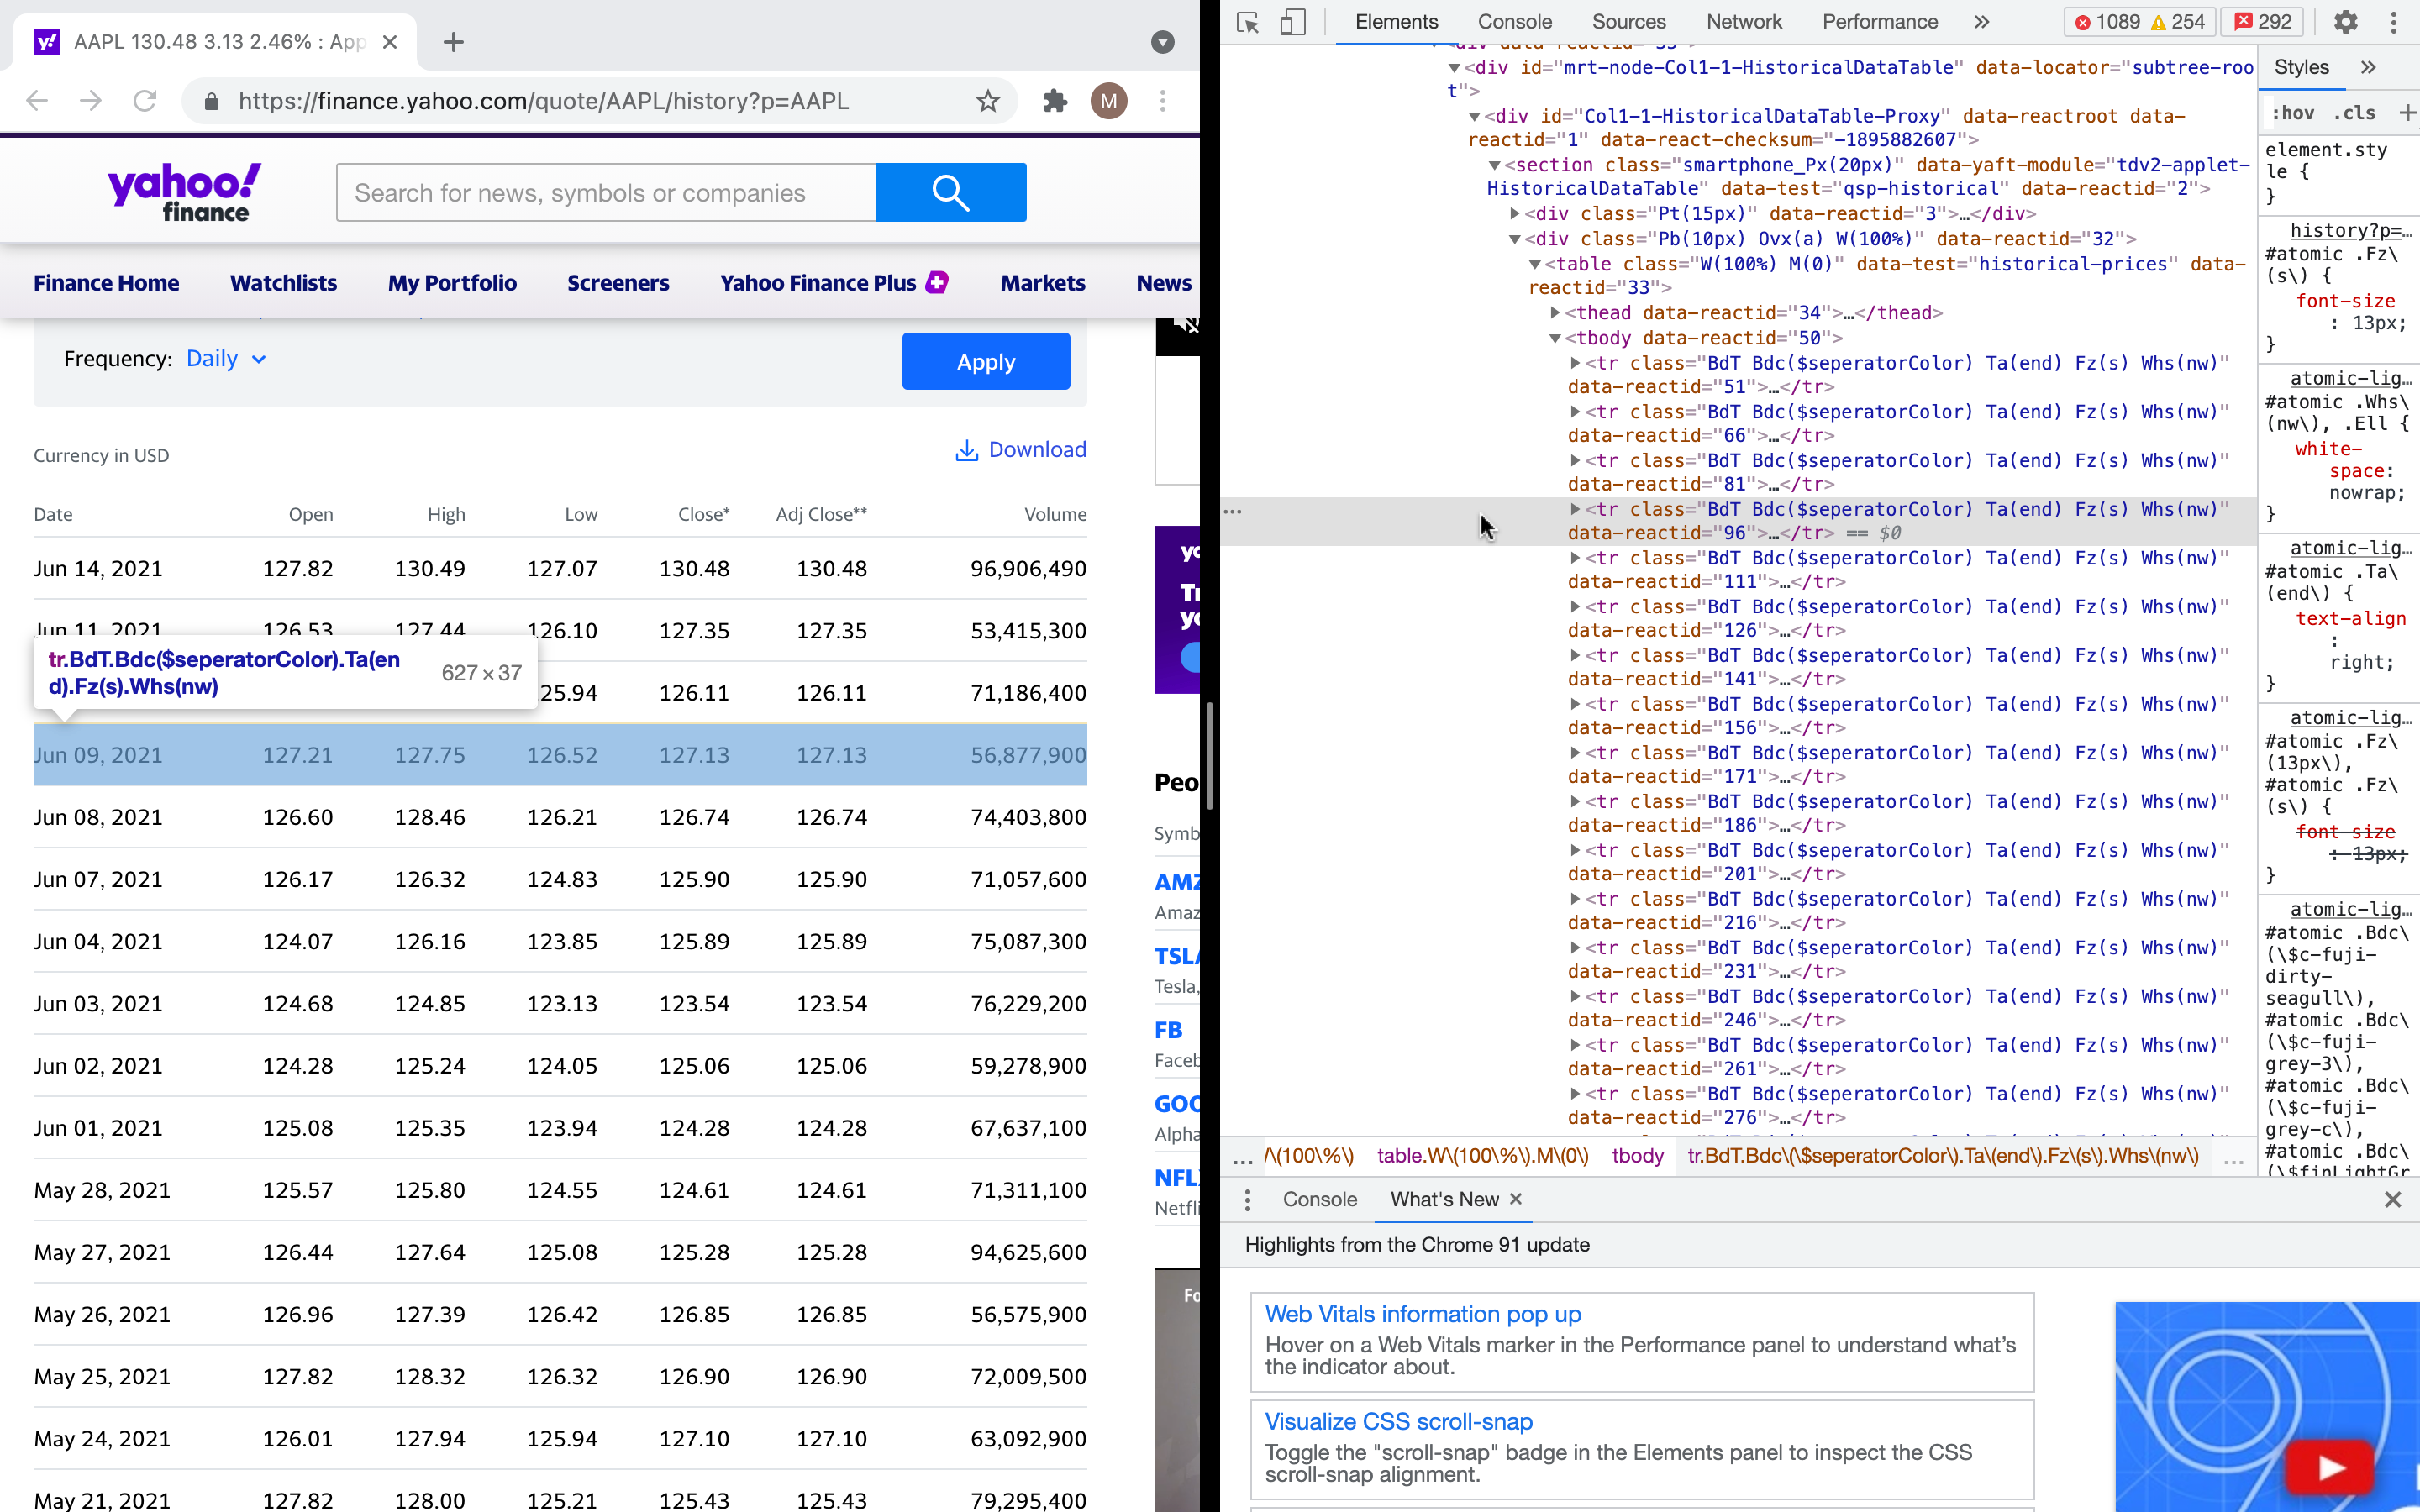

Inside of every *tr* element, each piece of data in a row is in a *td* element. Further, it seems to always be true that the only text in the *td* element is the data we're looking for.

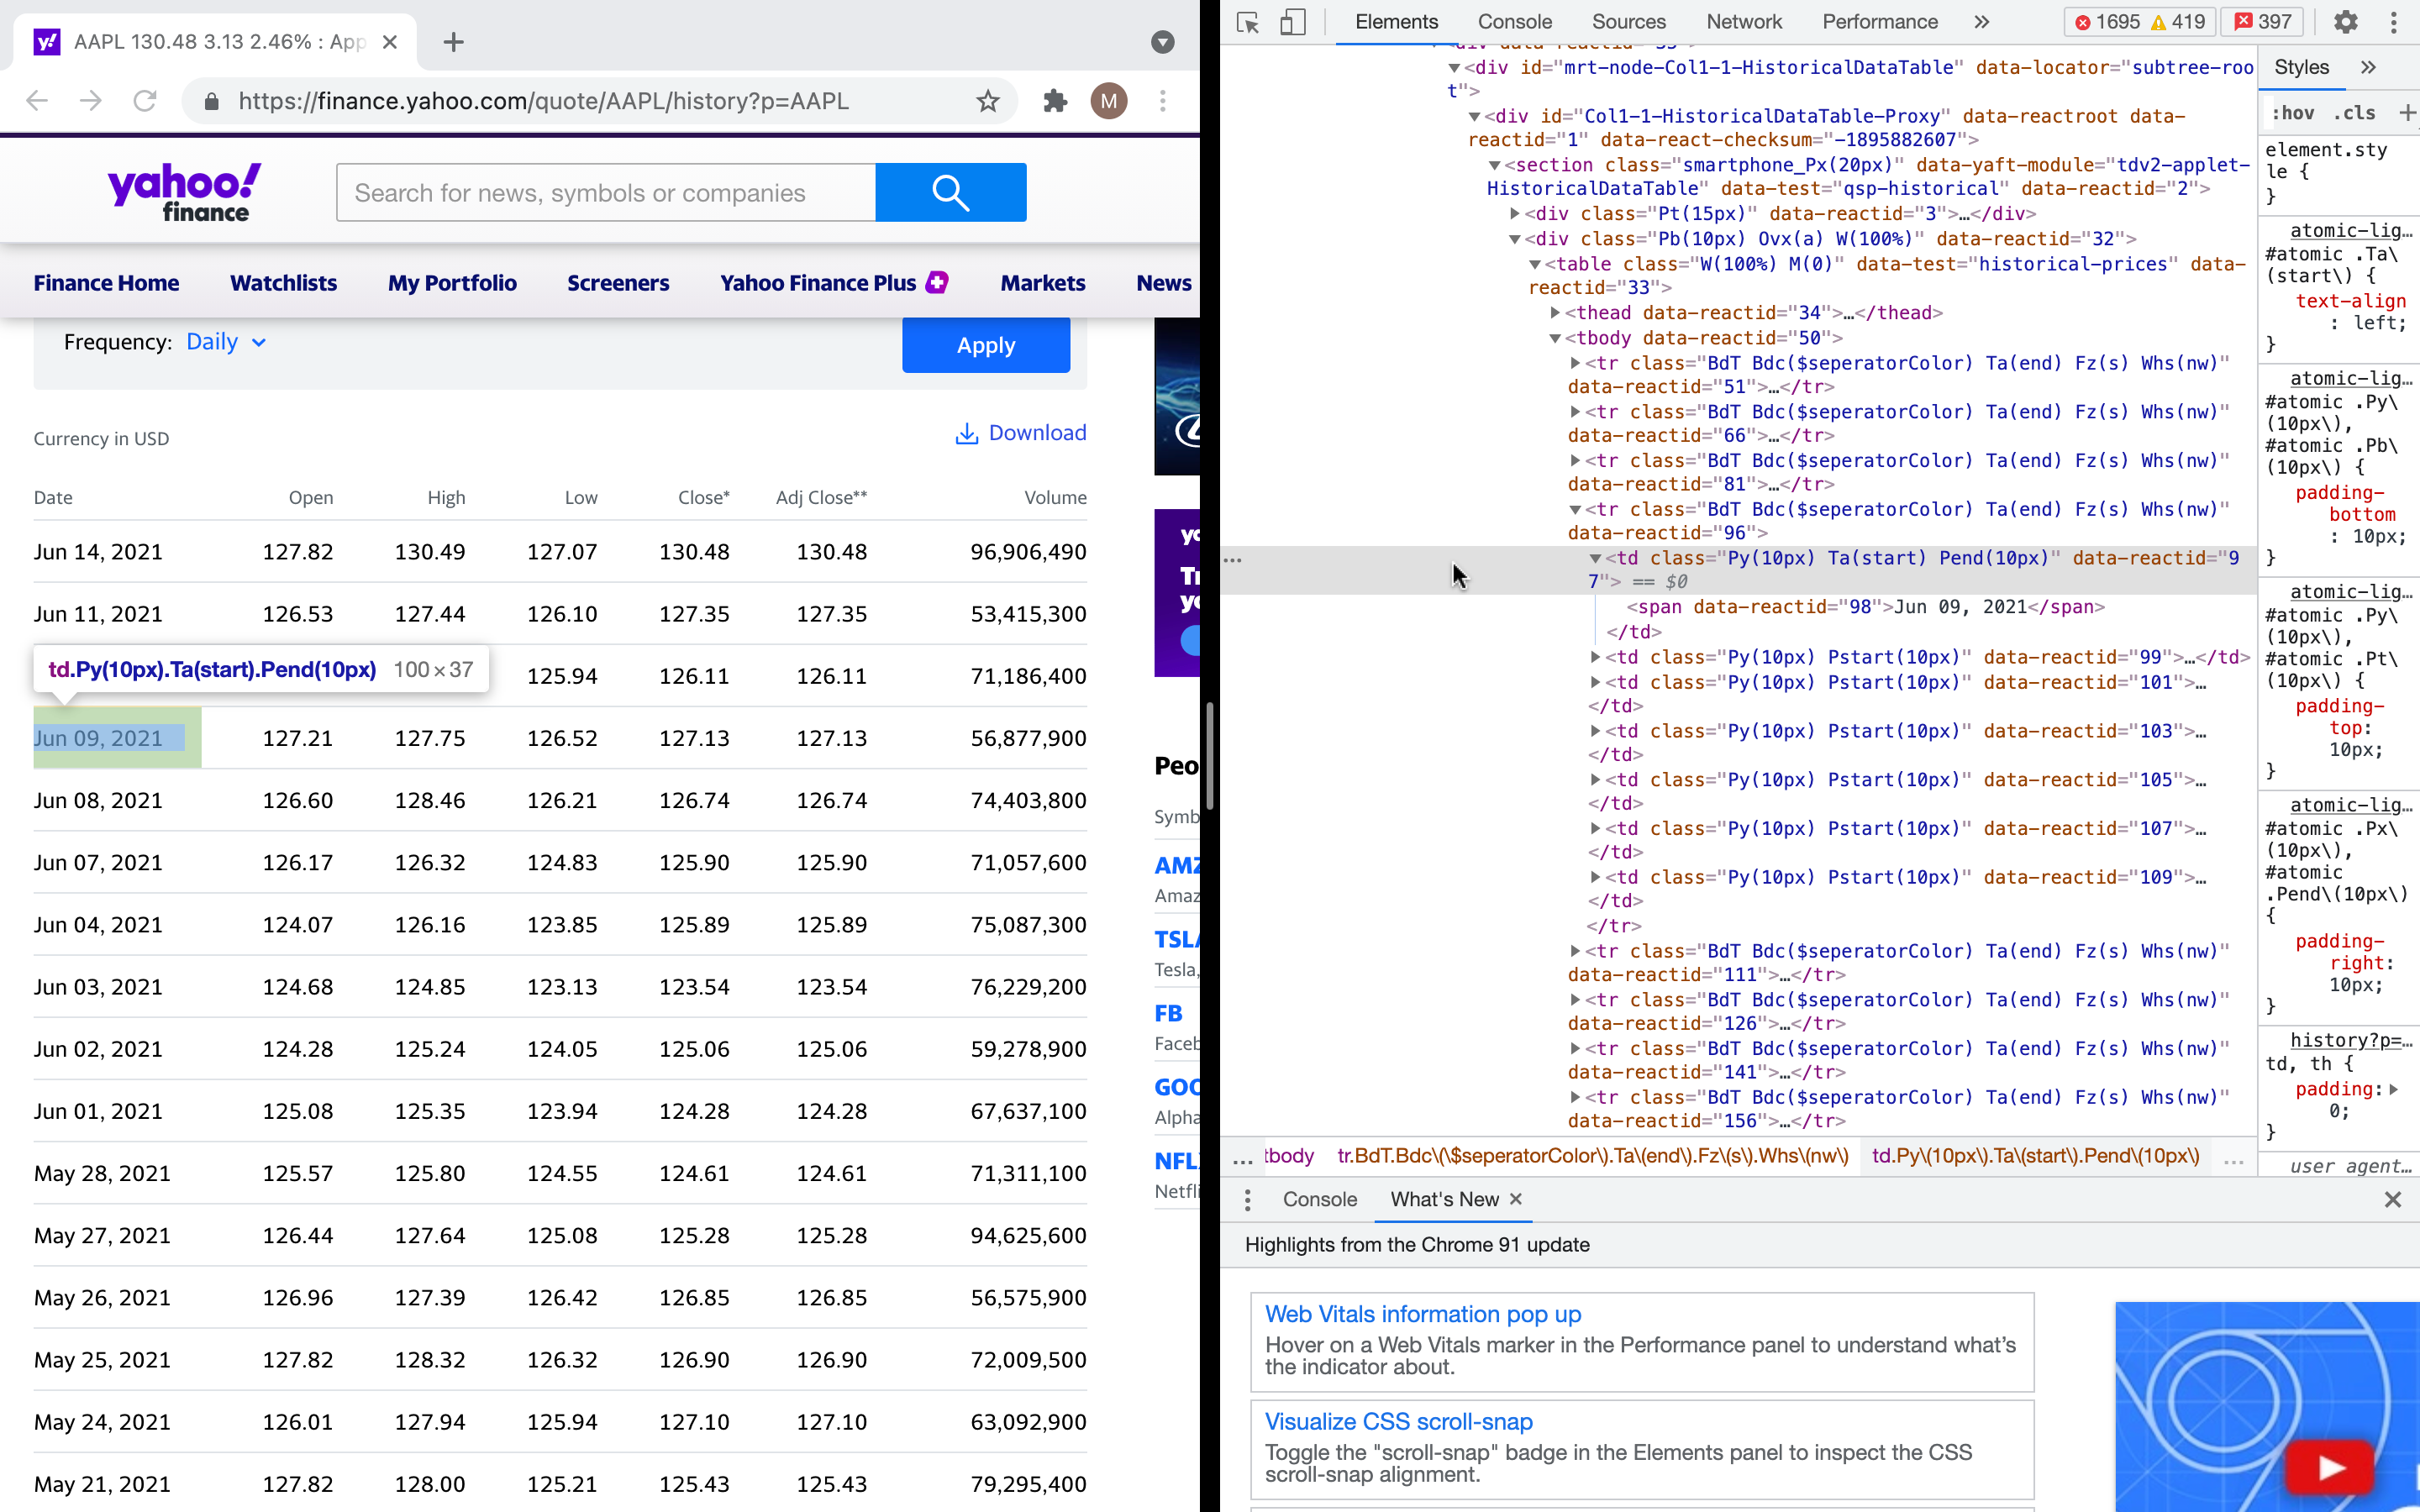

This suggests that, to get all of the information in the table, we should look for the *table* element with the attribute data-test="historical-prices"; inside this element we should look for the *tbody* element; inside this element we should look for all of the *tr* elements to get all of the rows in the table; and inside each *tr* element we should look for all of the *td* elements and extract their text.

### Code

Now that we have a plan of attack, we can start writing code.

In [ ]:
#the website we want to scrape
url = "https://finance.yahoo.com/quote/AAPL/history?period1=1577836800&period2=1609372800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true"

#the user-agent header must be present
legitimateUserAgent = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.99 Safari/537.36"
headers = {"user-agent": legitimateUserAgent}

#standard boilerplate code we use every time we do web scraping
page = requests.get(url, headers=headers)
soup = BeautifulSoup(page.content, 'html.parser')

historicalPricesTable = soup.find("table", attrs={"data-test": "historical-prices"})
for row in historicalPricesTable.tbody.find_all("tr"):
    #the print statements are for nice formatting
    for data in row.find_all("td"):
        print(data.text, end="  ")
    print()

The above code cell seems to obtain all of the stock data for Apple in the year 2020.

## Problem 2: Dynamically loaded data

### Encountering the problem

If we check the last line of output of [the code cell above](#scrollTo=PIlAU8Zk5Df0), we should notice that we actually do not have access to all of the stock data for Apple in the year 2020; it only goes back to August 12th. What happened? 

The issue is that when we ask for a lot of stock information, Yahoo Finance only loads 100 rows in the table, even if it would require more than 100 rows to display all of it. It loads the rest of the information [**dynamically**](#scrollTo=vQ8QxnlPDDaT); once we scroll far enough down the page to see the end of the first 100 rows, Yahoo Finance loads 100 more. 

Since we're getting our information from the website without scrolling down the page, we only obtain the first 100 rows in the table. How do we get past this?

### Solving the problem

We can use Selenium, which allows us to automate browser interactions, such as scrolling down the page.

In order to use Selenium in Google Colab, we first need to install some things,



In [ ]:
!pip install selenium
!apt-get update
!apt install chromium-chromedriver

then import some libraries,

In [ ]:
#allows us to automate browser interactions
from selenium import webdriver

#we will need this later to tell our program to wait for data to load
import time

and finally open up a web browser (the options here are required in order to use Selenium in Colab without crashing; this code comes directly from [this StackOverflow answer](https://stackoverflow.com/a/61157968) with modifications from [this other answer to the same question](https://stackoverflow.com/a/69465005)).

In [ ]:
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver',options=options)

Now that we have a web browser open, we can navigate to the page that we want to scrape:

In [ ]:
url = "https://finance.yahoo.com/quote/AAPL/history?period1=1577836800&period2=1609372800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true"
driver.get(url)

We want to keep scrolling all the way down the page until there is no more data to be loaded. We can do that by first checking the height of the page, then scrolling all the way down, and checking the height again. If the height changed, that means that more data was loaded, and we have not reached the end of the page yet. If the height did not change, that means that no more data was loaded, and we have reached the end of the page. So, we just keep scrolling all the way down the page until the height of the page stops changing.

In [ ]:
#get height of the page
documentHeight = driver.execute_script("return document.documentElement.scrollHeight")

while True:
    #scroll all the way down the page
    #E010 is the END key; when pressed, this goes to the bottom of the page
    webdriver.ActionChains(driver).send_keys("\uE010").perform()

    #wait for more data to load
    time.sleep(2)

    #if the page is the same height after scrolling down,
    #then we've reached the end of the page and we should break out of the loop
    newHeight = driver.execute_script("return document.documentElement.scrollHeight")
    if documentHeight == newHeight:
        break

    #if not, then set documentHeight to the new value
    documentHeight = newHeight
    print( newHeight ) #this is helpful for debugging to see how tall the page is after scrolling

Now that we have scrolled all the way down the page, we should have access to all of the data we are looking for. We can extract this data using the same web scraping techniques that we are already familiar with:

In [ ]:
#page_source is the HTML of the page that we just scrolled down
soup = BeautifulSoup(driver.page_source)

#the rest of the scraping code remains the same
historicalPricesTable = soup.find("table", attrs={"data-test": "historical-prices"})
for row in historicalPricesTable.tbody("tr"):
    for data in row("td"):
        print(data.text, end="  ")
    print()

Notice that the last line of output is January 2nd, 2020, so now we have retrieved all of the data we were looking for.

## Glossary

* ***Web scraping*** - the process of extracting information from websites ([Back](#scrollTo=EVJr-EUjaH2P))

* ***API*** - short for Application Programming Interface, this is a list of functions that you can call for a particular application/service. On a website, instead of forcing a user or programmer to interact with their raw data, often they will provide a list of functions (API) so that the user can interact with the website’s data in a clean way.

* ***Developer Tools*** - this is a set of resources we can use to learn more about the website we're on. Here we can see the Elements, Console, Sources, and Network sections, in addition to a few others. Elements shows us the HTML of the page, and this is the only part of Developer Tools we use during this class. Console shows us any messages sent by the website, Sources shows us the code that makes up the website (it's more than just HTML), and Network shows us the online resources the website uses. ([Back](#scrollTo=JCGAZHmhi6X-))

* ***HTML*** - hypertext markup language, it’s the code that tells our browser how to render (display) a particular webpage. Below is an example of what HTML looks like.

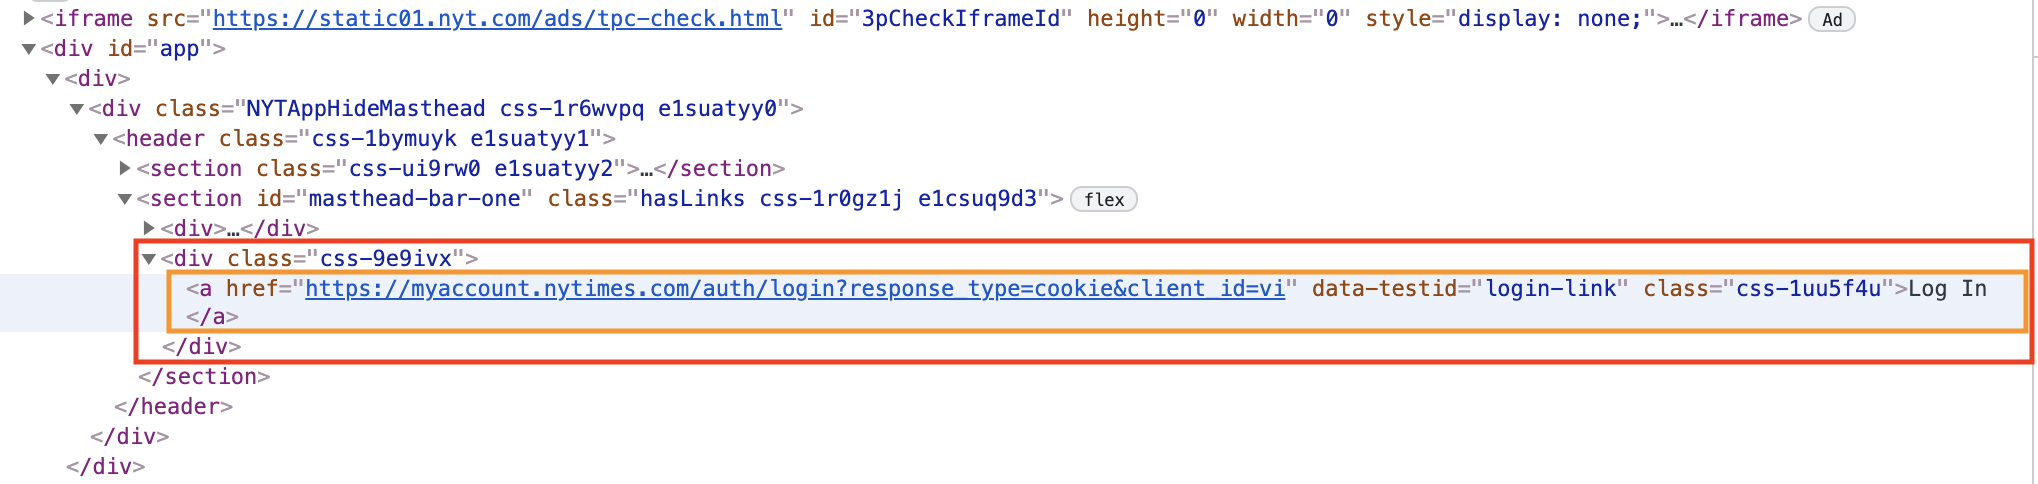


* ***Element (HTML)*** - a part of a webpage. An element may contain data, a chunk of text or an image, or perhaps nothing. A typical element consists of an opening tag with some attributes, enclosed text content, and a closing tag. The orange and red boxes in the image above are both elements (an element can contain another element). ([Back](#scrollTo=JCGAZHmhi6X-))

* ***Tag (HTML)*** - used for creating an element, we can think of a tag as the name of an element, and it is the purple text inside of angle brackets, like \<p\> for paragraph. The tag tells us what the purpose of an element is. In the image below, the *a* inside the blue circle is the tag of that element. Notice that tags are italicized throughout this notebook. ([Back](#scrollTo=JCGAZHmhi6X-))

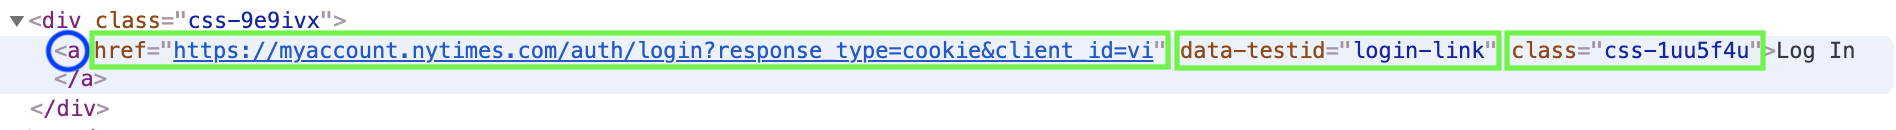


* ***Attributes (HTML)*** - an attribute changes an element’s behavior or provides information about the element. The green boxes in the above image are all of the attributes of the *a* element. ([Back](#scrollTo=JCGAZHmhi6X-))

* ***Library/Package*** - code written by other people that we can use in our own programs. We use an import statement to get access to the code in a library/package. Library and package mean the same thing, so I will use them interchangeably. ([Back](#scrollTo=rCjaepU_uAai))

* ***Open (stock price)*** - price of a stock at the beginning of the period being discussed. Since we're only discussing daily stock prices, this is the price when trading begins for the day. ([Back](#scrollTo=LFtl4pGScaPM))

* ***High (stock price)*** - highest price of a stock during the period being discussed. ([Back](#scrollTo=LFtl4pGScaPM))

* ***Low (stock price)*** - lowest price of a stock during the period being discussed. ([Back](#scrollTo=LFtl4pGScaPM))

* ***Close (stock price)*** - price of a stock at the end of the period being discussed. Since we're only discussing daily stock prices, this is the price when trading ends for the day. ([Back](#scrollTo=LFtl4pGScaPM))

* ***Adjusted Close (stock price)*** - this is the close price after some modifications. ([Back](#scrollTo=LFtl4pGScaPM))

* ***Volume (stock)*** - amount of stocks traded during the period being discussed. Since we're only discussing daily stock prices, this is the number of stocks traded during the day. ([Back](#scrollTo=LFtl4pGScaPM))

* **Request Headers** - a part of an HTTP request that contains additional information about that request. This information is in the form of key-value pairs, with a colon separating the key and the value. ([Back](#scrollTo=qcX_Pp_jr-2Z))

* ***Dynamic Web Pages*** - a web page is considered dynamic if its content and appearance depend on the user and the user's actions. For example, if the user has expressed a preference for dark mode, then a dynamic web page might display its content in dark mode to that user. If the user scrolls all the way down the page, a dynamic web page might load more content for the user to look at (this is a simplified version of how the feed works in social media sites like Instagram, Facebook, and TikTok). ([Back](#scrollTo=gmrcn9zNCfo5))

## Places to Continue Learning

* [Installing Python](https://realpython.com/installing-python/)
    * If you would like to run Python code without requiring an internet connection, you need to install it locally on your computer. This link contains great instructions on how to do that.
* [Selenium Webdriver for Python](https://pypi.org/project/selenium/)
    * This link contains instructions on how to install and use Selenium with Python.
* [Selenium Webdriver Documentation](https://www.selenium.dev/documentation/webdriver/)
* [StackOverflow post on how to use Selenium in Google Colab](https://stackoverflow.com/questions/51046454/how-can-we-use-selenium-webdriver-in-colab-research-google-com)
* [Beautiful Soup Documentation](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)
* [Information on User-Agent](https://developer.mozilla.org/en-US/docs/Web/HTTP/Headers/User-Agent)
* [Codes for each key on a keyboard](https://www.w3.org/TR/webdriver/#keyboard-actions)
* [Web Scraping Tutorial](https://realpython.com/beautiful-soup-web-scraper-python/)
* [Automate the Boring Stuff with Python by Al Sweigart](https://automatetheboringstuff.com/)
    * This is a great book that shows how to write Python programs that perform useful and time-consuming tasks in a fraction of a second. One of the topics the author discusses is web scraping (Chapter 12), but he uses different functions in Beautiful Soup than the ones we used in this class, so it's still an interesting read. This link is to the book itself, which is available online for free!


In addition to the above resources, NYPL offers free courses on Linkedin Learning to anyone with a library card. We recommend the following courses on that platform:
* Working with Databases
    1. [MySQL Installation and Configuration](https://www.linkedin.com/learning/mysql-installation-and-configuration/)
        * After scraping a website for some data, we may need some place to store that data. For that, we could use a database. MySQL is a free, popular database management system, and this course covers how to install and set it up.
    2. [Advanced Python: Working with Databases](https://www.linkedin.com/learning/advanced-python-working-with-databases)
        * Chapter 3 of this course covers how to use MySQL with Python.
    3. [MySQL Essential Training](https://www.linkedin.com/learning/mysql-essential-training-2?u=73722380)
        * This course covers how to use MySQL in general and also serves as a good introduction to SQL, the most common language used to communicate with databases.
* [Python Data Analysis](https://www.linkedin.com/learning/python-data-analysis-2/)
    * This is a course on data analysis in Python. It covers Python data structures like lists, tuples, dictionaries, and sets; great features in Python like comprehensions and the collections and itertools modules; and it spends a lot of time talking about numpy and pandas, which are great for dealing with data and doing math with it.
* [Python for Data Science Essential Training](https://www.linkedin.com/learning/python-for-data-science-essential-training-part-1/) 
    * This is a comprehensive course on data science in Python. In chapter 6 it covers web scraping with Beautiful Soup, so that is another place to look at for additional review on that topic.